Project #5: Video Stitching and Processing 

## CS445: Computational Photography

### Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
# modify to where you store your project data including utils
datadir = "/Users/isaac/OneDrive/Desktop/UIUC/CS445/cs445_proj5_starter/mp5/" 

utilfn = datadir + "utils.py"

!copy "$utilfn" .
imagesfn = datadir + "images"
!copy -r "$imagesfn" .

import sys
print(sys.version)

The file cannot be copied onto itself.
        0 file(s) copied.
The system cannot find the file specified.3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]



In [1]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit to use SIFT

!pip install opencv-contrib-python --user

!pip install ffmpeg-python 


import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

### Part I: Stitch two key frames 

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.

Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image.

In [34]:
def score_projection(pt1, pt2):
    '''
    Score corresponding to the number of inliers for RANSAC
    Input: pt1 and pt2 are 2xN arrays of N points such that pt1[:, i] and pt2[:,i] should be close in Euclidean distance if they are inliers
    Outputs: score (scalar count of inliers) and inliers (1xN logical array)
    '''

    # TO DO
    
    du = pt2[0, :] - pt1[0, :]
    dv = pt2[1, :] - pt1[1, :]

    # Calculate the inliers based on the Euclidean distance and the threshold
    inliers = np.sqrt(du**2 + dv**2) < 0.7

    # Calculate the score as the sum of inliers
    score = np.sum(inliers)

    return score, inliers


def auto_homography(Ia,Ib, homography_func=None,normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.SIFT_create() #removed the xfeatures2d
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0
    n_to_sample = 4 # Put the correct number of points here maybe is 4

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, n_to_sample, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (computeHomography)

        
        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        
        score_t, inliers_t = score_projection(Xb[:2,:]/Xb[2,:], Xb_[:2,:]/Xb_[2,:])
        
        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = inliers_t
    
    print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

In [35]:
def computeHomography(pts1, pts2,normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD. Normalization is optional.
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    # TO DO
    num_points = pts1.shape[1]

    A = np.zeros((2 * num_points, 9))

    for i in range(num_points):
        x, y = pts1[0, i], pts1[1, i]
        u, v = pts2[0, i], pts2[1, i]
        A[2*i] = [-x, -y, -1, 0, 0, 0, x * u, y * u, u]
        A[2*i + 1] = [0, 0, 0, -x, -y, -1, x * v, y * v, v]

    _, _, V = svd(A)

    homography_matrix = np.reshape(V[-1], (3, 3))

    return homography_matrix


    



In [36]:
# images location
im1 = './images/input/frames/f0270.jpg'
im2 = './images/input/frames/f0450.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im2 = cv2.imread(im2)

H = auto_homography(im1,im2, computeHomography)
print(H)
H = H * (1.0 / H[2, 2])
print(H)

best score: 110.000000
[[ 4.84221415e-03  2.77170640e-04 -9.96645816e-01]
 [ 6.62257261e-05  4.65196152e-03 -8.14669632e-02]
 [ 1.90142595e-06  5.07063053e-07  3.88371585e-03]]
[[ 1.24679929e+00  7.13673838e-02 -2.56621713e+02]
 [ 1.70521554e-02  1.19781202e+00 -2.09765509e+01]
 [ 4.89589357e-04  1.30561316e-04  1.00000000e+00]]


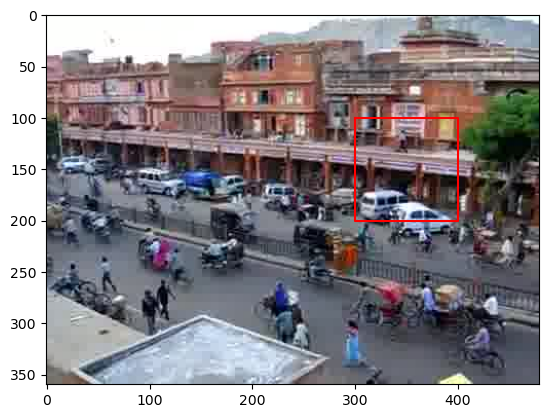

[[ 1.24679929e+00  7.13673838e-02 -2.56621713e+02]
 [ 1.70521554e-02  1.19781202e+00 -2.09765509e+01]
 [ 4.89589357e-04  1.30561316e-04  1.00000000e+00]]
[[300 400 400 300 300]
 [100 100 200 200 100]
 [  1   1   1   1   1]]


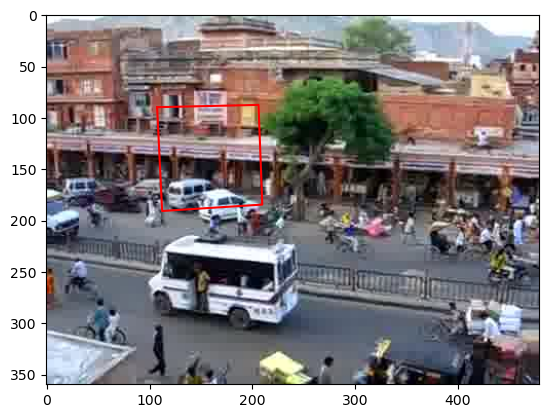

In [37]:
# plot the frames here
box_pts = np.array([[300, 400, 400, 300, 300], [100, 100, 200, 200, 100], [1, 1, 1, 1, 1]])
plt.figure()
plt.imshow(im1[:,:,[2,1,0]])
plt.plot(box_pts[0,:], box_pts[1, :], 'r-')
plt.show()

# TO DO: project points into im2 and display the projected lines on im2
print(H)
print(box_pts)

transformed_pts = np.dot(H, box_pts)


for i in range(transformed_pts.shape[1]):
    transformed_pts[:, i] /= transformed_pts[2, i]
    
plt.imshow(im2[:,:,[2,1,0]])

plt.plot(transformed_pts[0,:], transformed_pts[1, :], 'r-')
plt.show()

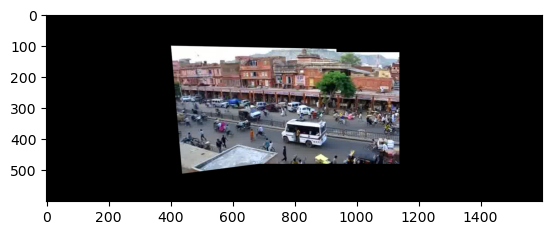

In [38]:
projectedWidth = 1600
projectedHeight = 600
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])

# TO DO: warp and blend the two images

canvas = np.zeros((projectedHeight, projectedWidth, 3), dtype=np.uint8)

position1 = (0, 0)  # top-left corner for img1
position2 = (660, 120)  
warped_img = cv2.warpPerspective(im1, np.dot(Tr,H), (projectedWidth, projectedHeight))

def place_image(canvas, image, position):
    x_offset, y_offset = position
    canvas[y_offset:y_offset+image.shape[0], x_offset:x_offset+image.shape[1]] = image

# Place each image on the canvas
place_image(canvas, warped_img, position1)
place_image(canvas, im2, position2)

# Display or save the result
plt.imshow(canvas[:,:,[2,1,0]])




### Part II: Panorama using five key frames

Produce a panorama by mapping five key frames [90, 270, 450, 630, 810] onto the same reference frame 450.  


best score: 150.000000
best score: 121.000000
best score: 104.000000
best score: 74.000000


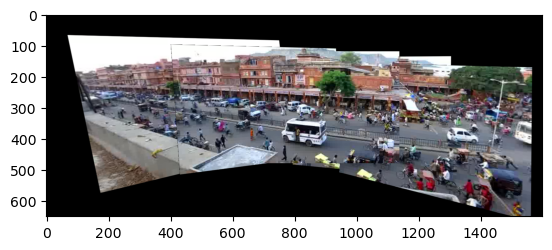

In [39]:
key_frames_idx = np.array([90, 270, 450, 630, 810])-1

frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(key_frames_idx)):
    frames[n] = cv2.imread("./images/input/frames/f0{num}.jpg".format(num=str(key_frames_idx[n]+1).zfill(3)))

# TO DO solution


H01 = auto_homography(frames[0], frames[1], computeHomography)
H12= auto_homography(frames[1], frames[2], computeHomography)
H32 = auto_homography(frames[3], frames[2], computeHomography) #2 is the reference
H43 = auto_homography(frames[4], frames[3], computeHomography)

H02 = np.dot(H01, H12)
H42 = np.dot(H43, H32)

projectedWidth = 1600
projectedHeight = 650
Tr = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]])

frame450 = frames[2]

frame90 = cv2.warpPerspective(frames[0], np.dot(Tr,H02), (projectedWidth, projectedHeight))
frame270 = cv2.warpPerspective(frames[1], np.dot(Tr,H12), (projectedWidth, projectedHeight))
frame630 = cv2.warpPerspective(frames[3], np.dot(Tr,H32), (projectedWidth, projectedHeight))
frame810 = cv2.warpPerspective(frames[4], np.dot(Tr,H42), (projectedWidth, projectedHeight))

canvas = np.zeros((projectedHeight, projectedWidth, 3), dtype=np.uint8)


offset_x, offset_y = 660, 120
position1 = (0,0)
position2 = (660,120)
position3 = (1320,240)
    
def blend_frames_onto_canvas(canvas, frames, frame450_position):
    for i in range(canvas.shape[0]):
        for j in range(canvas.shape[1]):
            for frame in frames:
                if frame[i, j].any():
                    canvas[i, j] = frame[i, j]
                    break
    x, y, w, h = frame450_position
    canvas[y:y+h, x:x+w, :] = frame450


frame450_position = (660, 120, 480, 360)  # (x, y, width, height)

frames_in_order = [frame810, frame630, frame270, frame90]

blend_frames_onto_canvas(canvas, frames_in_order, frame450_position)
plt.imshow(canvas[:,:,[2,1,0]])

### Part 3: Map the video to the reference plane

Project each frame onto the reference frame (using same size panorama) to create a video that shows the portion of the panorama revealed by each frame

In [40]:
# read all the images
import os 
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.imread(file_i)

print(len(frames))


900


In [41]:
# TO DO part 3 solution
projectedWidth = 1800
projectedHeight = 600
# create your video (see tips)
'''def compute_homography_to_ref(current_frame, ref_frame, H_key_to_ref):
    H_current_to_key = auto_homography(current_frame, ref_frame, computeHomography)
    return np.dot(H_key_to_ref, H_current_to_key)'''

output_video = cv2.VideoWriter('output_video.avi', cv2.VideoWriter_fourcc(*'XVID'), 30, (projectedWidth, projectedHeight))

new_ref_indices = [100, 200, 300, 400, 500, 600, 700, 800]
homographies_to_ref = {}

for ref_idx in new_ref_indices:
    homographies_to_ref[ref_idx] = auto_homography(frames[ref_idx], frames[450], computeHomography)

translation_matrix = np.array([[1, 0, 800], 
                               [0, 1, 0],   
                               [0, 0, 1]])   

for idx, frame in enumerate(frames):
    print(idx)
    closest_ref_idx = min(new_ref_indices, key=lambda x: abs(x - idx))
    
    H_to_ref = homographies_to_ref.get(closest_ref_idx, np.eye(3))
    H_current_to_closest_ref = auto_homography(frame, frames[closest_ref_idx], computeHomography)
    final_homography = np.dot(H_to_ref, H_current_to_closest_ref)

    # Combine the final homography with the translation matrix
    final_homography_shifted = np.dot(translation_matrix, final_homography)

    warped_frame = cv2.warpPerspective(frame, final_homography_shifted, (projectedWidth, projectedHeight))
    output_video.write(warped_frame)

output_video.release()
#utils.vidwrite_from_numpy(fnOut, fgframes[:,:,:,[2,1,0]], framerate=30)


best score: 50.000000
best score: 63.000000
best score: 103.000000
best score: 172.000000
best score: 158.000000
best score: 95.000000
best score: 45.000000
best score: 39.000000
0
best score: 274.000000
1
best score: 274.000000
2
best score: 265.000000
3
best score: 264.000000
4
best score: 300.000000
5
best score: 282.000000
6
best score: 288.000000
7
best score: 285.000000
8
best score: 307.000000
9
best score: 316.000000
10
best score: 333.000000
11
best score: 319.000000
12
best score: 321.000000
13
best score: 308.000000
14
best score: 316.000000
15
best score: 325.000000
16
best score: 338.000000
17
best score: 340.000000
18
best score: 318.000000
19
best score: 332.000000
20
best score: 326.000000
21
best score: 313.000000
22
best score: 321.000000
23
best score: 324.000000
24
best score: 325.000000
25
best score: 297.000000
26
best score: 322.000000
27
best score: 345.000000
28
best score: 328.000000
29
best score: 339.000000
30
best score: 339.000000
31
best score: 308.000000

best score: 431.000000
302
best score: 337.000000
303
best score: 330.000000
304
best score: 280.000000
305
best score: 476.000000
306
best score: 296.000000
307
best score: 240.000000
308
best score: 272.000000
309
best score: 240.000000
310
best score: 252.000000
311
best score: 264.000000
312
best score: 232.000000
313
best score: 246.000000
314
best score: 261.000000
315
best score: 203.000000
316
best score: 206.000000
317
best score: 189.000000
318
best score: 218.000000
319
best score: 194.000000
320
best score: 207.000000
321
best score: 217.000000
322
best score: 198.000000
323
best score: 222.000000
324
best score: 221.000000
325
best score: 185.000000
326
best score: 194.000000
327
best score: 210.000000
328
best score: 191.000000
329
best score: 190.000000
330
best score: 196.000000
331
best score: 204.000000
332
best score: 172.000000
333
best score: 170.000000
334
best score: 210.000000
335
best score: 163.000000
336
best score: 172.000000
337
best score: 185.000000
338
b

best score: 296.000000
606
best score: 233.000000
607
best score: 199.000000
608
best score: 207.000000
609
best score: 221.000000
610
best score: 222.000000
611
best score: 193.000000
612
best score: 188.000000
613
best score: 174.000000
614
best score: 198.000000
615
best score: 161.000000
616
best score: 168.000000
617
best score: 144.000000
618
best score: 166.000000
619
best score: 123.000000
620
best score: 200.000000
621
best score: 151.000000
622
best score: 155.000000
623
best score: 154.000000
624
best score: 117.000000
625
best score: 153.000000
626
best score: 183.000000
627
best score: 153.000000
628
best score: 144.000000
629
best score: 146.000000
630
best score: 145.000000
631
best score: 121.000000
632
best score: 134.000000
633
best score: 114.000000
634
best score: 132.000000
635
best score: 150.000000
636
best score: 113.000000
637
best score: 101.000000
638
best score: 113.000000
639
best score: 131.000000
640
best score: 130.000000
641
best score: 114.000000
642
b

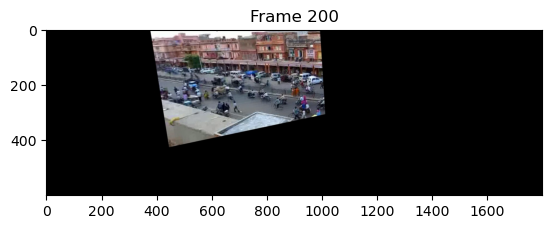

In [45]:

video_path = 'output_video.avi'
cap = cv2.VideoCapture(video_path)

if cap.isOpened():
    # Jump to frame 200
    frame_idx = 200
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    
    ret, frame_200 = cap.read()  # Read the frame
    if ret:
        # Convert the color from BGR to RGB
        frame_200_rgb = cv2.cvtColor(frame_200, cv2.COLOR_BGR2RGB)

        # Display the frame using matplotlib
        plt.imshow(frame_200_rgb)
        plt.title("Frame 200")
        plt.show()
    else:
        print(f"Error: Could not read frame {frame_idx}.")

    # Release the video capture object
    cap.release()
else:
    print("Error: Could not open video.")

### Part 4: Create background panorama

Create a background panorama based on the result from Part 3.


KeyboardInterrupt: 

### Part 5: Create background movie

Generate a movie that looks like the input movie but shows only background pixels. For each frame of the movie, you need to estimate a projection from the panorama to that frame. Your solution can use the background image you created in Part 4 and the per-frame homographies you created in Part 3. 


In [ ]:
# TO DO part 5



### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that emphasizes or includes only foreground pixels.

In [ ]:
# TO DO part 6


## Bells and whistles